In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/E_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/L_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/N_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/S_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/D_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/G_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/I_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/W_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/M_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/nothing_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/X_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/H_test.jpg
/kaggle/input/asl-alphabet/asl_a

In [ ]:
!pip install mediapipe 


In [19]:
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
train_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
output_dir = '/kaggle/working/cropped_hands'

classes = sorted(os.listdir(train_dir))
print(f"Classes: {classes} ...")

In [14]:
# Initialize MediaPipe ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5
)

W0000 00:00:1761236109.249320     149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761236109.283913     149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [12]:
# Extract Landmarks Function ---
def extract_landmarks(image_path):
    """Extract 21 hand landmarks (63 features: x, y, z for each point)"""
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        coords = []
        for lm in landmarks.landmark:
            coords.extend([lm.x, lm.y, lm.z])
        return np.array(coords)  # 63 features
    return None

In [15]:
X_data = []
y_data = []

classes = sorted(os.listdir(train_dir))
print(f"Found {len(classes)} classes: {classes}")

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    print(f"Processing class: {class_name}")
    files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    success_count = 0
    for file in tqdm(files, desc=f"Extracting {class_name}", leave=False):
        img_path = os.path.join(class_path, file)
        landmarks = extract_landmarks(img_path)
        
        if landmarks is not None:
            X_data.append(landmarks)
            y_data.append(class_name)
            success_count += 1
    
    print(f"  ✅ Extracted {success_count}/{len(files)} samples")

print(f"\n✅ Total samples extracted: {len(X_data)}")

Found 29 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Processing class: A


  ✅ Extracted 2187/3000 samples
Processing class: B


  ✅ Extracted 2207/3000 samples
Processing class: C


  ✅ Extracted 1988/3000 samples
Processing class: D


  ✅ Extracted 2463/3000 samples
Processing class: E


  ✅ Extracted 2308/3000 samples
Processing class: F


  ✅ Extracted 2876/3000 samples
Processing class: G


  ✅ Extracted 2440/3000 samples
Processing class: H


  ✅ Extracted 2393/3000 samples
Processing class: I


  ✅ Extracted 2384/3000 samples
Processing class: J


  ✅ Extracted 2578/3000 samples
Processing class: K


  ✅ Extracted 2700/3000 samples
Processing class: L


  ✅ Extracted 2527/3000 samples
Processing class: M


  ✅ Extracted 1565/3000 samples
Processing class: N


  ✅ Extracted 1276/3000 samples
Processing class: O


  ✅ Extracted 2265/3000 samples
Processing class: P


  ✅ Extracted 2042/3000 samples
Processing class: Q


  ✅ Extracted 2093/3000 samples
Processing class: R


  ✅ Extracted 2541/3000 samples
Processing class: S


  ✅ Extracted 2551/3000 samples
Processing class: T


  ✅ Extracted 2349/3000 samples
Processing class: U


  ✅ Extracted 2516/3000 samples
Processing class: V


  ✅ Extracted 2548/3000 samples
Processing class: W


  ✅ Extracted 2456/3000 samples
Processing class: X


  ✅ Extracted 2158/3000 samples
Processing class: Y


  ✅ Extracted 2585/3000 samples
Processing class: Z


  ✅ Extracted 2351/3000 samples
Processing class: del


  ✅ Extracted 1701/3000 samples
Processing class: nothing


  ✅ Extracted 3/3000 samples
Processing class: space


  ✅ Extracted 1625/3000 samples

✅ Total samples extracted: 63676


In [16]:
# Remove "nothing" class samples (only has 3 samples)
print(f"Before filtering: {len(X_data)} samples")

# Find indices where class is NOT "nothing"
keep_indices = [i for i, label in enumerate(y_data) if label.lower() != 'nothing']

# Filter both X and y
X_data_filtered = [X_data[i] for i in keep_indices]
y_data_filtered = [y_data[i] for i in keep_indices]

# Replace original data
X_data = X_data_filtered
y_data = y_data_filtered

print(f"After filtering: {len(X_data)} samples")
print(f"Removed 'nothing' class")

# Check remaining classes
unique_classes = sorted(set(y_data))
print(f"Training on {len(unique_classes)} classes: {unique_classes}")

Before filtering: 63676 samples
After filtering: 63673 samples
Removed 'nothing' class
Training on 28 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space']


In [20]:
X = np.array(X_data)
y = np.array(y_data)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.15, random_state=42, stratify=y_encoded
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Feature dimension: {X_train.shape[1]} (21 landmarks × 3 coordinates)")


Training samples: 54122
Validation samples: 9551
Number of classes: 28
Feature dimension: 63 (21 landmarks × 3 coordinates)


In [21]:
num_classes = len(label_encoder.classes_)

model = Sequential([
    Dense(256, activation='relu', input_shape=(63,)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Cell 7: Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('asl_landmarks_best.h5', save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761238724.537110      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,148 (238.86 KB)

 Trainable params: 60,252 (235.36 KB)

 Non-trainable params: 896 (3.50 KB)

In [22]:
# Train Model 
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


I0000 00:00:1761238745.926344     172 service.cc:148] XLA service 0x7eb6bc001200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761238745.927016     172 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761238746.312893     172 cuda_dnn.cc:529] Loaded cuDNN version 90300


 64/423 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1852 - loss: 3.1837

I0000 00:00:1761238748.803018     172 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


423/423 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5729 - loss: 1.6229 - val_accuracy: 0.8323 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9318 - loss: 0.2596 - val_accuracy: 0.8763 - val_loss: 0.3824 - learning_rate: 0.0010
Epoch 3/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9424 - loss: 0.2080 - val_accuracy: 0.9122 - val_loss: 0.2529 - learning_rate: 0.0010
Epoch 4/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9468 - loss: 0.1837 - val_accuracy: 0.8882 - val_loss: 0.3229 - learning_rate: 0.0010
Epoch 5/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9458 - loss: 0.1852 - val_accuracy: 0.9077 - val_loss: 0.3322 - learning_rate: 0.0010
Epoch 6/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9484 - loss: 0.1788 - val_accuracy: 0.9524 - val_loss: 0.1438 - learning_rate: 0.0010
Epoch 7/100
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9548 - loss: 0.1603 - val

In [23]:
model.save('asl_landmarks_final.h5')
with open('asl_landmarks_classes.pkl', 'wb') as f:
    pickle.dump(label_encoder.classes_, f)

print("✅ Model and classes saved successfully!")

✅ Model and classes saved successfully!


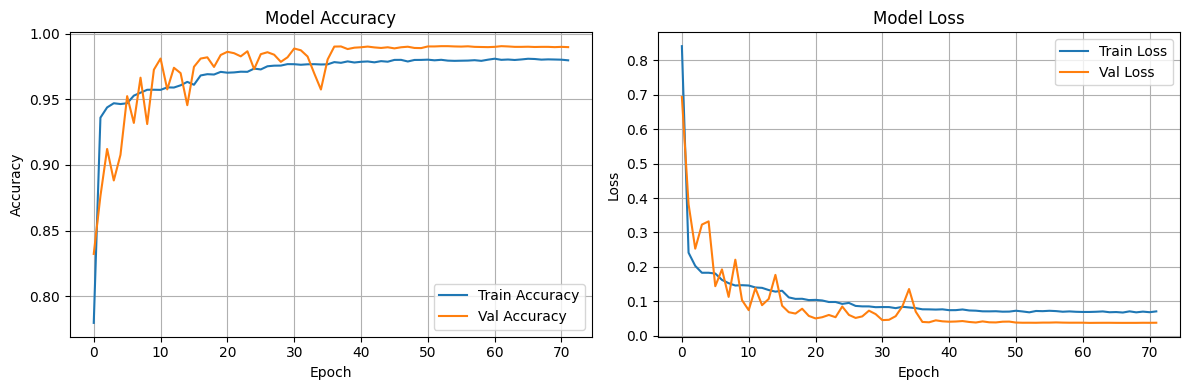

In [24]:
# Cell 10: Visualize Training
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"\n📊 Final Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"📊 Final Validation Loss: {val_loss:.4f}")


📊 Final Validation Accuracy: 99.04%
📊 Final Validation Loss: 0.0372
